In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from scipy.special import erf, hermite, jvp
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1001)

In this notebook we showcase the ability of Gaussian Process Regression to estimate arbitrary derivatives as well as the first antiderivatives of the underlying function. In order to do so we extend the GaussianProcessRegressor from scikit-learn.

In our case we fix the kernel of the regression to Constant Kernel * RBF. However other kernels would work as well as long as they are integrable/differentiable.


In [18]:
class GPR:
    def __init__(self, rbf_length_scale=1.0, rbf_length_scale_bounds=(1e-5, 1e5),
                 constant_length_scale=1.0, constant_length_scale_bounds=(1e-5, 1e5),
                 **kwargs):
        """
        Gaussian Process Regressor built on top of sklearn's one. The kernel is fixed to 
        Constant Kernel * RBF where the inital values and bounds can be set through the arguments. 
        All other kwargs can be used analogosly to the base class. 
        Since the implementation of sklearn doesn't allow for inheriting from the base Class
        in a straightforward way we instead use the GaussianProcessRegressor as a variable        

        Args:
            rbf_length_scale (float, optional): The length scale of the RBF Kernel. Defaults to 1.0.
            rbf_length_scale_bounds ((float, float), optional): The lower and upper bound on 'rbf_length_scale'. Defaults to (1e-5, 1e5).
            constant_length_scale (float, optional): The length scale of the Constant Kernel. Defaults to 1.0.
            constant_length_scale_bounds ((float, float), optional): The lower and upper bound on 'constant_value'. Defaults to (1e-5, 1e5).
            **kwargs (TYPE): kwargs for the GaussianProcessRegressor class.

        Returns:
            None.

        """
        
        self._gpr = GaussianProcessRegressor(ConstantKernel(constant_length_scale, constant_length_scale_bounds)
                                             * RBF(rbf_length_scale, rbf_length_scale_bounds), 
                                             **kwargs)
        
    def _gaussian(self, x, l=1):
        return np.exp(-1 * x**2 / (2 * l**2))

    def _gaussian_antiderivative(self, x, l=1):
        return np.sqrt(np.pi / 2) * l * erf(x / (np.sqrt(2) * l))                                       

    def _gaussian_derivative(self, x, l, k=1):
        return (-1)**k * (1 / (2 * l**2))**(k / 2) * self._gaussian(x, l=l) * hermite(k)(x / (np.sqrt(2) * l))
        
    def fit(self, X, Y):
        """
        Fit the GP Regressor for the samples X and targets Y

        Args:
            X (array-like of shape (n_samples,)): The feature vector.
            Y (array-like of shape (n_samples,)): The target values.

        Returns:
            None.

        """
        self._gpr.fit(X.reshape(-1, 1), Y)
        
    def predict(self, X, k=0):
        """
        Predict the GP Regressor on the values X

        Args:
            X (array-like of shape (n_samples,)): The query vector.
            k (int, optional): The order of the prediction. Set k == 1, 2, ... for the k-th derivatives,
                               and k == -1 for the first antiderivative of the underlying function. 
                               Higher order antiderivatives are not implemented yet. For k == 0 we get 
                               the basic estimate, identical to the one from the original 
                               GaussianProcessRegressor. Defaults to 0.

        Raises:
            NotImplementedError: Quering for higher order antiderivates is not yet supported.

        Returns:
            ndarray of shape (n_samples,): The prediction vector.

        """        
        c = self._gpr.kernel_.k1.constant_value
        l = self._gpr.kernel_.k2.length_scale
        A = self._gpr.alpha_
        m = self._gpr._y_train_mean
        X_diff = X.reshape(-1, 1) - self._gpr.X_train_.reshape(1, -1)
        
        if k == 0:
            return c * self._gaussian(X_diff, l=l) @ A + m
        
        elif k > 0:
            return c * self._gaussian_derivative(X_diff, l, k=k) @ A

        elif k == -1:
            return c * self._gaussian_antiderivative(X_diff, l) @ A + m * X.reshape(-1, 1)
        
        else:
            raise NotImplementedError('Higher order antiderivatives not implemented')

To test our Regressor we use the fourth derivative of the Bessel function of the first kind as our underlying ground truth. The choice for this function and order is due to its easy avaliablity of derivatives as well as the antiderivative

In [19]:
def f(X, k=0):
    return jvp(7, X, n=k + 4)

n_samples = 20  # how many sample points do we take of our function

X_train = np.random.uniform(-15, 15, n_samples)
Y_train = f(X_train)

X_test = np.linspace(-20, 20, 200)

Let us take a look at the data


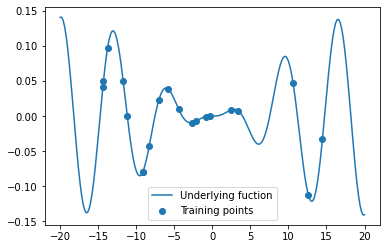

In [20]:
Y_test = f(X_test, k=0)

plt.plot(X_test, Y_test, label='Underlying fuction')
plt.scatter(X_train, Y_train, label='Training points')
plt.legend()
plt.show()

Now we create our Regressor and train it on the provided data


In [21]:
gpr = GPR()
gpr.fit(X_train, Y_train.reshape(-1, 1))

First we take a look at the prediction of the underlying function


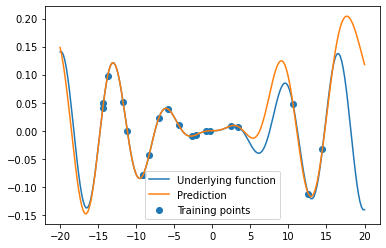

In [22]:
k = 0  # the order of the derivative/antiderivative
Y_predict = gpr.predict(X_test, k=k)
Y_test = f(X_test, k=k)

plt.scatter(X_train, Y_train, label='Training points')
plt.plot(X_test, Y_test, label='Underlying function')
plt.plot(X_test, Y_predict, label='Prediction')

plt.legend()
plt.show()

Then we examine the prediction of its 3rd derivative


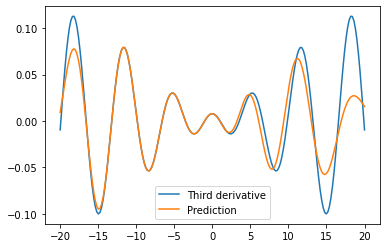

In [23]:
k = 3  # the order of the derivative/antiderivative
Y_predict = gpr.predict(X_test, k=k)
Y_test = f(X_test, k=k)

plt.plot(X_test, Y_test, label='Third derivative')
plt.plot(X_test, Y_predict, label='Prediction')
plt.legend()
plt.show()

Lastly we want to see how well the prediction for the antiderivative worked. Since those aren't uniquely defined we compute the definite integral from 0 to x.

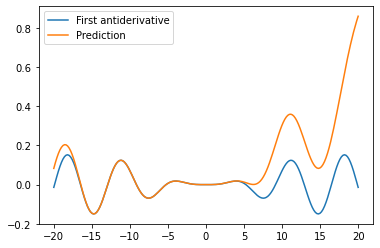

In [24]:
k = -1  # the order of the derivative/antiderivative
Y_predict = gpr.predict(X_test, k=k) - gpr.predict(np.array(0), k=k)
Y_test = f(X_test, k=k) - f(0, k=k)

plt.plot(X_test, Y_test, label='First antiderivative')
plt.plot(X_test, Y_predict, label='Prediction')
plt.legend()
plt.show()